# Chapter 6 - Statistical Machine Learning

Import required Python packages

In [62]:
import math
import os
import random
from pathlib import Path
from collections import defaultdict
from itertools import product


import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from dmba import plotDecisionTree, textDecisionTree

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib inline

Paths for data sets.

In [64]:
LOAN200_CSV = r"\Personal\Full_Stack_Data_Analyst\Data_Science\O-Reilly_Books\Practical Statistics for Data Scientists\data\loan200.csv"
LOAN3000_CSV = r"\Personal\Full_Stack_Data_Analyst\Data_Science\O-Reilly_Books\Practical Statistics for Data Scientists\data\loan3000.csv"
LOAN_DATA_CSV = r"\Personal\Full_Stack_Data_Analyst\Data_Science\O-Reilly_Books\Practical Statistics for Data Scientists\data\loan_data.csv"

# K-Nearest Neighbors

# A Sample Example: Predicting Loan Default

The `scikit-learn` package provides a fast and efficient implementation of KNN in _Python_:

In [66]:
loan200 = pd.read_csv(LOAN200_CSV)

predictors = ['payment_inc_ratio', 'dti']
outcome = 'outcome'

newloan = loan200.loc[0:0, predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
knn.predict(newloan)
print(knn.predict_proba(newloan))

[[0.45 0.55]]


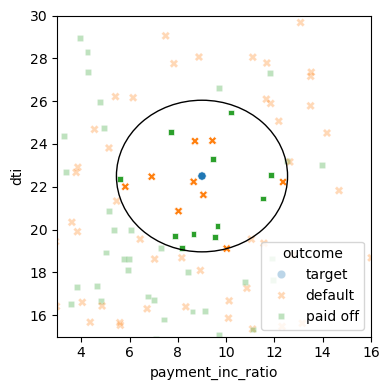

In [67]:
nbrs = knn.kneighbors(newloan)
maxDistance = np.max(nbrs[0][0])

fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome',
               hue='outcome', data=loan200, alpha=0.3, ax=ax)
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', data=pd.concat([loan200.loc[0:0, :], 
                                               loan200.loc[nbrs[1][0] + 1,:]]),ax=ax, legend=False)
ellipse = Ellipse(xy=newloan.values[0], width=2 * maxDistance, height=2 * maxDistance,
                 edgecolor='black', fc='None', lw=1)
ax.add_patch(ellipse)
ax.set_xlim(3, 16)
ax.set_ylim(15, 30)

plt.tight_layout()
plt.show()

# Distance Metrics

# One Hot Encoder

# Standardization (Normalization, z-Scores)

The value of `revol_bal` in these neighbors is very close to its value in the new record, but the other predictor variables are all over the map and essentially play no role in determining neighbors.

In [69]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'],
                                    categories=['paid off', 'default'],
                                    ordered=True)

predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0, predictors]
print(newloan)
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

nbrs = knn.kneighbors(newloan)
print(X.iloc[nbrs[1][0], :])

   payment_inc_ratio  dti  revol_bal  revol_util
0             2.3932  1.0       1687         9.4
       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


Compare this to KNN applied to the standardized data using the `sklearn.preprocessing.StandardScaler` method. It is first trained with the predictors and is subsequently used to transform the set prior to training the KNN model:

In [71]:
newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

scaler = preprocessing.StandardScaler()
scaler.fit(X * 10)

X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


# Choosing K

# KNN as a Feature Engine

For the loan data, we can create features that represent different aspects of the loan process with `scikit-learn`, we use the `predict-proba` method of the trained model to get the probabilities:

count    45342.000000
mean         0.501091
std          0.128728
min          0.000000
25%          0.400000
50%          0.500000
75%          0.600000
max          0.950000
Name: borrower_score, dtype: float64


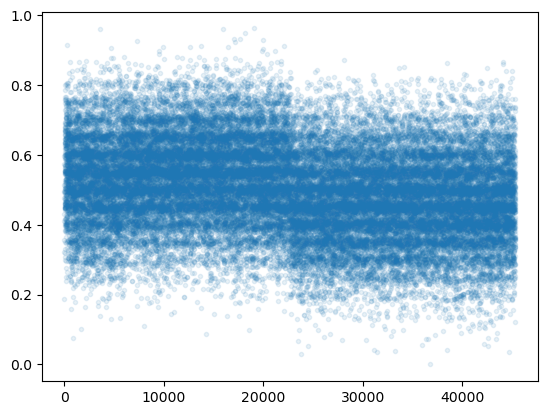

In [73]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 
              'delinq_2yrs_zero', 'pub_rec_zero']
outcome = 'outcome'

X = loan_data[predictors]
y = loan_data[outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
plt.scatter(range(len(X)), [bs + random.gauss(0, 0.015) for bs in knn.predict_proba(X)[:,0]], 
            alpha=0.1, marker='.')
knn.predict_proba(X)[:, 0]

loan_data['borrower_score'] = knn.predict_proba(X)[:, 0]
print(loan_data['borrower_score'].describe())

# Tree Models

# A Simple Example

The `sklearn.tree.DecisionTreeClassifier` provides an implementation of a decision tree. the `dmba` package provides a convenience function to create a visualization:

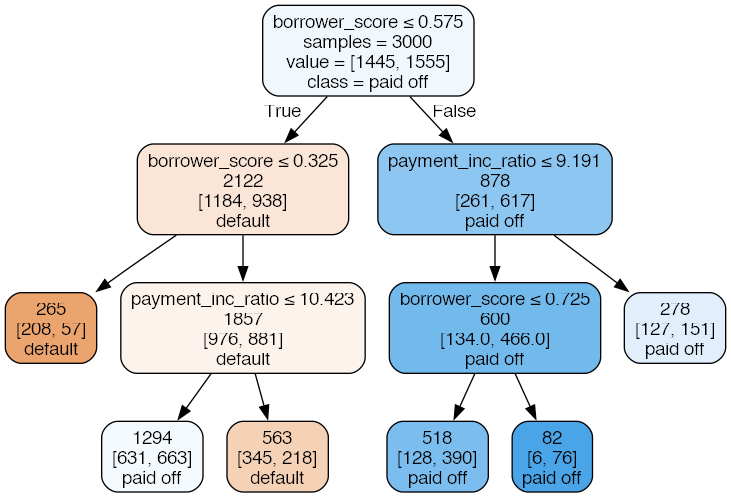

In [75]:
loan3000 = pd.read_csv(LOAN3000_CSV)

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy',
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)
plotDecisionTree(loan_tree, feature_names=predictors, class_names=loan_tree.classes_)

The `scikit-learn` documentation describes how to create a text representation of a decision tree model. We included a convenience function in our `dmba` package:

In [77]:
print(textDecisionTree(loan_tree))

node=0 test node: go to node 1 if 0 <= 0.5750000178813934 else to node 6
  node=1 test node: go to node 2 if 0 <= 0.32500000298023224 else to node 3
    node=2 leaf node: [[0.785, 0.215]]
    node=3 test node: go to node 4 if 1 <= 10.42264986038208 else to node 5
      node=4 leaf node: [[0.488, 0.512]]
      node=5 leaf node: [[0.613, 0.387]]
  node=6 test node: go to node 7 if 1 <= 9.19082498550415 else to node 10
    node=7 test node: go to node 8 if 0 <= 0.7249999940395355 else to node 9
      node=8 leaf node: [[0.247, 0.753]]
      node=9 leaf node: [[0.073, 0.927]]
    node=10 leaf node: [[0.457, 0.543]]


# The Recursive Partitioning Algorithm

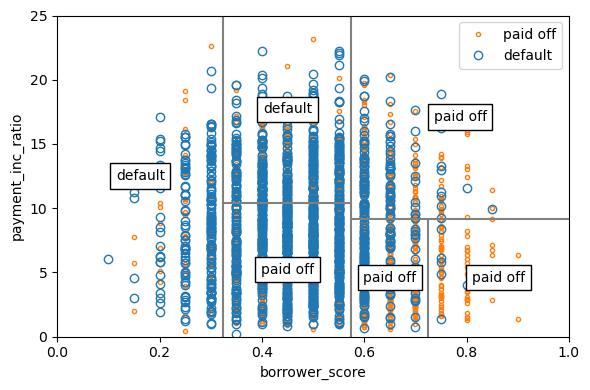

In [79]:
fig, ax = plt.subplots(figsize=(6,4))

loan3000.loc[loan3000.outcome=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio',style='.',
    markerfacecolor='none', markeredgecolor='C1',ax=ax)
loan3000.loc[loan3000.outcome=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default'])
ax.set_xlim(0,1)
ax.set_ylim(0,25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

x0 = 0.575
x1a = 0.325; y1b = 9.191
y2a = 10.423; x2b = 0.725
ax.plot((x0,x0),(0,25), color='grey')
ax.plot((x1a,x1a),(0,25), color='grey')
ax.plot((x0,1),(y1b,y1b), color='grey')
ax.plot((x1a,x0),(y2a,y2a), color='grey')
ax.plot((x2b,x2b),(0,y1b), color='grey')

labels = [('default', (x1a / 2, 25 / 2)),
         ('default', ((x0 + x1a) / 2, (25 + y2a) / 2)),
         ('paid off', ((x0 + x1a) / 2, y2a / 2)),
         ('paid off', ((1 + x0) / 2, (25 + y1b) / 2)),
         ('paid off', ((1 + x2b) / 2, (y1b + 0) / 2)),
         ('paid off', ((x0 + x2b) / 2, (y1b + 0) / 2)),
         ]

for label, (x, y) in labels:
    ax.text(x, y, label, bbox={'facecolor': 'white'},
           verticalalignment='center', horizontalalignment='center')

plt.tight_layout()
plt.show()

# Measuring Homogeneity or Impurity

In [81]:
def entropyFunction(x):
    if x ==0: return 0
    return -x * math.log(x, 2) - (1 - x) * math.log(1 - x, 2)

def giniFunction(x):
    return x * (1 - x)

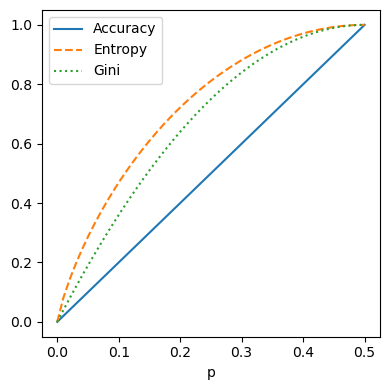

In [82]:
x = np.linspace(0,0.5,50)
impure = pd.DataFrame({
    'p': x,
    'Accuracy': 2 * x,
    'Gini': [giniFunction(xi) / giniFunction(.5) for xi in x],
    'Entropy': [entropyFunction(xi) for xi in x],
})

fig, ax = plt.subplots(figsize=(4,4))

impure.plot(x='p', y='Accuracy', ax=ax, linestyle='solid')
impure.plot(x='p', y='Entropy', ax=ax, linestyle='--')
impure.plot(x='p', y='Gini', ax=ax, linestyle=':')

plt.tight_layout()
plt.show()

# Random Forest

In _Python_, we use the method `sklearn.ensemble.RandomForestClassifier`:

In [100]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

rf = RandomForestClassifier(n_estimators=500, random_state=1, 
                            oob_score=True)
rf.fit(X, y)
print(rf.oob_decision_function_)

[[0.18131868 0.81868132]
 [0.26704545 0.73295455]
 [0.93333333 0.06666667]
 ...
 [1.         0.        ]
 [0.73157895 0.26842105]
 [0.68085106 0.31914894]]


The `RandomForestClassifier` implementation has no easy way to get out-of-bag estimates as a function of number of trees in the random forest. We can train a sequence of classifiers with an increasing number of trees and keep track if the `oob_score_values`. This method is, however, not efficient:

In [114]:
n_estimator = list(range(20, 510, 5))
oobScores = []
for n in n_estimator:
    rf = RandomForestClassifier(n_estimators=n, 
                                criterion='entropy', max_depth=5,
                                random_state=1, oob_score=True)
    rf.fit(X, y)
    oobScores.append(rf.oob_score_)

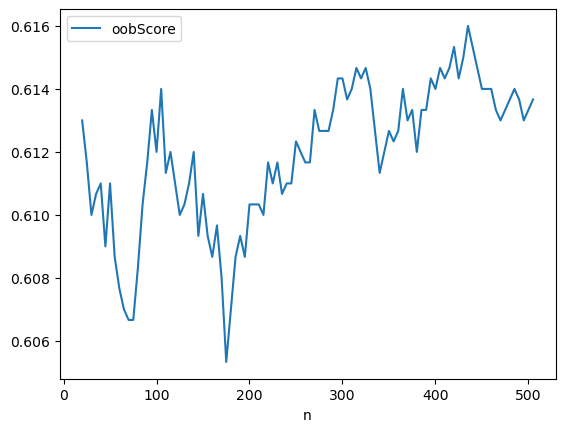

In [115]:
pd.DataFrame({
    'n': n_estimator, 
    'oobScore': oobScores
}).plot(x='n', y='oobScore')
plt.show()

The predicted values can be obtained in _Python_, we can create a similar plot as follows:

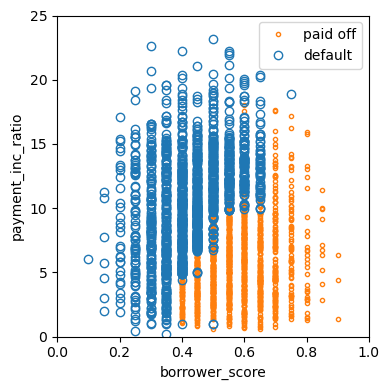

In [120]:
predictions = X.copy()
predictions['prediction'] = rf.predict(X)
predictions.head()

fig, ax = plt.subplots(figsize=(4,4))

predictions.loc[predictions.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
predictions.loc[predictions.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)

ax.legend(['paid off', 'default']);
ax.set_xlim(0,1)
ax.set_ylim(0,25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()

# Variable Importance

This is different to R. The accuracy decrease is not available out of the box.

In [123]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True, dtype=int)
y = loan_data[outcome]

rf_all = RandomForestClassifier(n_estimators=500, random_state=1)
rf_all.fit(X, y)
rf_all_entropy = RandomForestClassifier(n_estimators=500, random_state=1,
                                       criterion='entropy')
print(rf_all_entropy.fit(X, y))

RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=1)


In [142]:
rf = RandomForestClassifier(n_estimators=500)
scores = defaultdict(list)
 
# crossvalidate the scores on a number of different random splits of the data
for _ in range(3):
    train_X, valid_X, train_y, valid_y = train_test_split(X, y, 
                                                          test_size=0.3)
    rf.fit(train_X, train_y)
    acc = metrics.accuracy_score(valid_y, rf.predict(valid_X))
    for column in X.columns:
        X_t = valid_X.copy()
        X_t[column] = np.random.permutation(X_t[column].values)
        shuff_acc = metrics.accuracy_score(valid_y, rf.predict(X_t))
        scores[column].append((acc-shuff_acc)/acc)
print('Features sorted by their score:')
print(sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True))

Features sorted by their score:
[(0.0775, 'borrower_score'), (0.035, 'grade'), (0.0312, 'term_60 months'), (0.012, 'payment_inc_ratio'), (0.0101, 'annual_inc'), (0.0039, 'open_acc'), (0.0022, 'dti'), (0.0015, 'purpose_small_business'), (0.0014, 'revol_util'), (0.0011, 'revol_bal'), (0.0011, 'purpose__small_business'), (0.0009, 'purpose__home_improvement'), (0.0007, 'purpose__other'), (0.0006, 'purpose__major_purchase'), (0.0004, 'purpose_wedding'), (0.0003, 'emp_length'), (0.0, 'purpose_vacation'), (0.0, 'purpose_major_purchase'), (0.0, 'purpose_house'), (-0.0, 'purpose_home_improvement'), (-0.0, 'purpose_credit_card'), (-0.0, 'purpose__medical'), (-0.0, 'home__OWN'), (-0.0001, 'purpose_moving'), (-0.0002, 'pub_rec_zero'), (-0.0002, 'emp_len__ > 1 Year'), (-0.0003, 'delinq_2yrs_zero'), (-0.0004, 'purpose__debt_consolidation'), (-0.0007, 'purpose_medical'), (-0.0008, 'purpose_other'), (-0.0009, 'purpose_debt_consolidation'), (-0.0013, 'home__RENT'), (-0.0025, 'loan_amnt')]


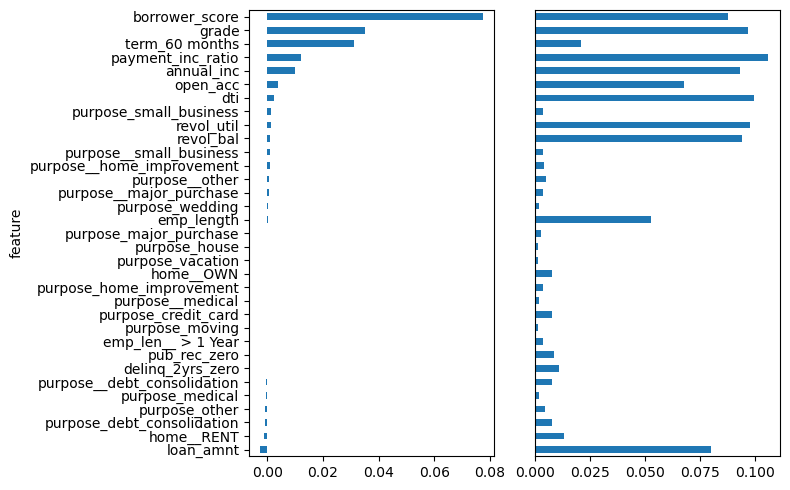

In [145]:
importances = rf_all.feature_importances_

df = pd.DataFrame({
    'feature': X.columns,
    'Accuracy decrease': [np.mean(scores[column]) for column in X.columns],
    'Gini decrease': rf_all.feature_importances_,
    'Entropy decrease': rf_all_entropy.feature_importances_,
})

df = df.sort_values('Accuracy decrease')

fig, axes = plt.subplots(ncols=2, figsize=(8,5))
ax = df.plot(kind='barh', x='feature', y='Accuracy decrease', legend=False,
            ax=axes[0])
ax = df.plot(kind='barh', x='feature', y='Gini decrease', legend=False,
            ax=axes[1])
ax.set_ylabel('')
ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()